In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
import joblib

In [18]:
# Load the dataset
df = pd.read_csv('customer_support_tickets.csv')

# --- Data Cleaning and Target Variable Creation ---

# Drop rows where 'Customer Satisfaction Rating' is NaN, as it's our target variable
df_cleaned = df.dropna(subset=['Customer Satisfaction Rating']).copy()

# Create the binary 'satisfied' target variable
df_cleaned['satisfied'] = (df_cleaned['Customer Satisfaction Rating'] >= 4).astype(int)

print("Shape after dropping NaNs in 'Customer Satisfaction Rating':", df_cleaned.shape)
print("\nDistribution of 'satisfied' target variable:")
print(df_cleaned['satisfied'].value_counts(normalize=True))

Shape after dropping NaNs in 'Customer Satisfaction Rating': (2769, 18)

Distribution of 'satisfied' target variable:
satisfied
0    0.60744
1    0.39256
Name: proportion, dtype: float64


In [ ]:
# --- Feature Engineering ---

# Convert relevant time columns to datetime objects.
df_cleaned['First Response Time'] = pd.to_datetime(df_cleaned['First Response Time'], errors='coerce')
df_cleaned['Time to Resolution'] = pd.to_datetime(df_cleaned['Time to Resolution'], errors='coerce')
df_cleaned['Date of Purchase'] = pd.to_datetime(df_cleaned['Date of Purchase'], errors='coerce')

# Calculate 'time_to_resolution_hours' and 'first_response_time_hours'
df_cleaned['time_to_resolution_hours'] = (df_cleaned['Time to Resolution'] - df_cleaned['First Response Time']).dt.total_seconds() / 3600
df_cleaned['first_response_time_hours'] = (df_cleaned['First Response Time'] - df_cleaned['Date of Purchase']).dt.total_seconds() / 3600

# Impute any NaN values in these newly engineered time features with their respective means.
df_cleaned['time_to_resolution_hours'].fillna(df_cleaned['time_to_resolution_hours'].mean(), inplace=True)
df_cleaned['first_response_time_hours'].fillna(df_cleaned['first_response_time_hours'].mean(), inplace=True)

# Feature: Create 'customer_age_group'
df_cleaned['customer_age_group'] = pd.cut(df_cleaned['Customer Age'],
                                          bins=[18, 30, 45, 60, 100],
                                          labels=['18-29', '30-44', '45-59', '60+'],
                                          right=False,
                                          include_lowest=True)


C:\Users\Hi\AppData\Local\Temp\ipykernel_23328\1849038298.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['time_to_resolution_hours'].fillna(df_cleaned['time_to_resolution_hours'].mean(), inplace=True)
C:\Users\Hi\AppData\Local\Temp\ipykernel_23328\1849038298.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

In [20]:
#Select the features (X) and the target variable (y).
X = df_cleaned.drop([
    'Ticket ID', 'Customer Name', 'Customer Email', 'Customer Satisfaction Rating',
    'satisfied', 'First Response Time', 'Time to Resolution',
    'Date of Purchase', 'Resolution', 'Ticket Description', 'Ticket Subject'
], axis=1, errors='ignore')
y = df_cleaned['satisfied']

print("\nFeatures (X) Head:")
print(X.head())
print("\nTarget (y) Head:")
print(y.head())


Features (X) Head:
    Customer Age Customer Gender          Product Purchased  \
2             48           Other                   Dell XPS   
3             27          Female           Microsoft Office   
4             67          Female           Autodesk AutoCAD   
10            48            Male            Nintendo Switch   
11            51            Male  Microsoft Xbox Controller   

             Ticket Type Ticket Status Ticket Priority Ticket Channel  \
2        Technical issue        Closed             Low   Social media   
3        Billing inquiry        Closed             Low   Social media   
4        Billing inquiry        Closed             Low          Email   
10  Cancellation request        Closed            High          Phone   
11       Product inquiry        Closed            High           Chat   

    time_to_resolution_hours  first_response_time_hours customer_age_group  
2                   6.850000               25259.233333              45-59  
3       

In [21]:
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print("\nSelected Numerical Features:", numerical_features)
print("Selected Categorical Features:", categorical_features)

# Define the ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])



Selected Numerical Features: ['Customer Age', 'time_to_resolution_hours', 'first_response_time_hours']
Selected Categorical Features: ['Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Status', 'Ticket Priority', 'Ticket Channel']


In [22]:

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")



Training set shape: (2215, 10), (2215,)
Test set shape: (554, 10), (554,)


In [23]:
print("\n--- Performing Hyperparameter Tuning for RandomForestClassifier with GridSearchCV ---")

# Define the pipeline steps: preprocessor -> SMOTE -> RandomForestClassifier
# The 'smote' step should come after preprocessing and before the final estimator.
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])


--- Performing Hyperparameter Tuning for RandomForestClassifier with GridSearchCV ---


In [ ]:
# Define the parameter grid for GridSearchCV
# We're tuning n_estimators and max_depth for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 150], # Number of trees
    'classifier__max_depth': [None, 10, 20], # Maximum depth of the tree
    'smote__sampling_strategy': ['auto', 0.75] # How much to resample minority class
}

In [ ]:
# Initialize GridSearchCV
# cv=3 for 3-fold cross-validation
# scoring='accuracy' can be changed to 'f1', 'roc_auc' etc. based on problem needs
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("\nBest cross-validation accuracy:")
print(grid_search.best_score_) 

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters found by GridSearchCV:
{'classifier__max_depth': 10, 'classifier__n_estimators': 150, 'smote__sampling_strategy': 0.75}

Best cross-validation accuracy:
0.596392986933929


In [26]:
# --- Evaluate the Best Model ---
best_model = grid_search.best_estimator_

print("\n--- Evaluating the Best Model from GridSearchCV on Test Set ---")
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


--- Evaluating the Best Model from GridSearchCV on Test Set ---
Accuracy: 0.5974729241877257

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.95      0.74       337
           1       0.39      0.05      0.09       217

    accuracy                           0.60       554
   macro avg       0.50      0.50      0.42       554
weighted avg       0.52      0.60      0.49       554


Confusion Matrix:
 [[320  17]
 [206  11]]


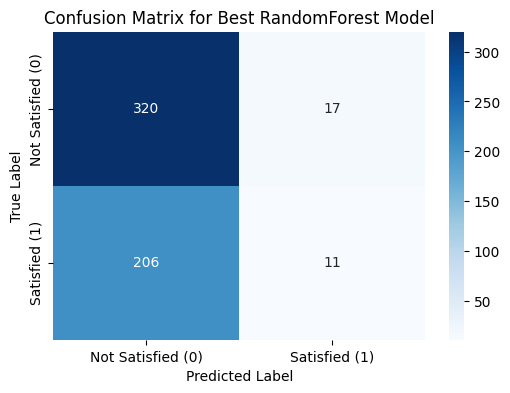

In [27]:
# Visualize Confusion Matrix for the best model
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Satisfied (0)', 'Satisfied (1)'], yticklabels=['Not Satisfied (0)', 'Satisfied (1)'])
plt.title('Confusion Matrix for Best RandomForest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [28]:
# --- Save the Best Model ---
joblib.dump(best_model, 'best_customer_satisfaction_model.pkl')
print("\nBest model (including preprocessor and SMOTE) saved as 'best_customer_satisfaction_model.pkl'")

# --- Optional: Evaluate Logistic Regression without extensive tuning for comparison ---
print("\n--- Evaluating Logistic Regression (for comparison, no extensive tuning here) ---")
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_lr))

joblib.dump(lr_pipeline, 'logistic_regression_customer_satisfaction_model.pkl')
print("Logistic Regression model saved as 'logistic_regression_customer_satisfaction_model.pkl'")


Best model (including preprocessor and SMOTE) saved as 'best_customer_satisfaction_model.pkl'

--- Evaluating Logistic Regression (for comparison, no extensive tuning here) ---
Accuracy (Logistic Regression): 0.51985559566787

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.62      0.54      0.58       337
           1       0.41      0.49      0.44       217

    accuracy                           0.52       554
   macro avg       0.51      0.51      0.51       554
weighted avg       0.54      0.52      0.53       554


Confusion Matrix (Logistic Regression):
 [[182 155]
 [111 106]]
Logistic Regression model saved as 'logistic_regression_customer_satisfaction_model.pkl'
